In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd '/gdrive/My Drive/TestXGBoost/dde'

/gdrive/My Drive/TestXGBoost/dde


In [ ]:
import numpy as np
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
#from google.colab import files
#import model
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import math
from keras.utils import np_utils
from tensorflow.keras.optimizers import SGD, RMSprop, Adadelta, Adam, Nadam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn import metrics
import json
#
from sklearn.model_selection import train_test_split 
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
#%matplotlib inline
# Evaluations
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from IPython.display import clear_output

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix

In [ ]:

## Chargement dataset
def load_data_set(org, dataset):
    path = './'
    pathResult="Results/"+org
    #ajout du nouveau fichier du dataset
    metaDataset = pd.read_csv(dataset+".csv",sep=";")
    print(metaDataset)
    row,col = metaDataset.shape
    count=1
    return (row,col,count,metaDataset,path,pathResult)

def main_preprocessing(epath_file, balance):
    row, col, count, metaDataset, path, pathResult = load_data_set(organism, dataset)
    for index in range(row):
        print("############################"+metaDataset['featureGroup'][index]+"############################################")
        print(str(count)+" / "+str(row))
        META_DATA_FILE_NAME=epath_file
        FEAT=str(metaDataset['code'][index])
        FEAT_FILE=os.path.join(path, str(metaDataset['filename'][index]))
        META_FILE=os.path.join(path, str(META_DATA_FILE_NAME))
        RESULT_FILE=os.path.join(pathResult, str(FEAT)+"_Result.json")
        
        print(FEAT_FILE+"\n")
        print(META_FILE+"\n")
        
        print(RESULT_FILE)
        #open file 
		#FILE_SAVE=open(RESULT_FILE, 'a')
        DICT_XGB=dict()
        DICT_RF=dict()
        # feature de epath
        feature_data = pd.read_csv(FEAT_FILE)
        print(feature_data)
        genes = feature_data.index
        
        meta_df = pd.read_excel(META_FILE, sheet_name="Sheet1",engine="openpyxl")
        #nom du champ pour identifier les gene Gene_Locus
        meta_idx = meta_df['Gene_Locus']
        meta_idx = pd.Series([x.upper() for x in meta_idx.values])
        meta_df = meta_df.set_index(keys=meta_idx)
        ddf =meta_df
        print(meta_df['Gene_essentaility'])
        
        # get class labels for dataset
		#remplace class par Gene_essentaility
        df_full = feature_data.merge(meta_df[['Gene_essentaility']], how='inner', left_index=True, right_index=True)
        
        #df_full.to_csv('dffullctdcsimple.csv')
		#Nucleotide feature
        if 'X' in df_full.columns:
            df_full.drop('X', axis = 1, inplace=True)
        
        mappings = {'NE': 0, 'E': 1}
        classes = df_full.pop('Gene_essentaility')
        essential_labels = classes.map(mappings)
        df_full['essential'] = essential_labels
        
        # remove unknowns
        df_full = df_full[df_full['essential'] < 2]
        dataset_full=df_full.copy()
        df_essential = df_full[df_full['essential'] == 1]
        df_nonEssential = df_full[df_full['essential'] == 0]
        
        if (balance == 1):
            # rebalance the classes
            df_essential_oversample = pd.concat([df_essential, df_essential], ignore_index=True)
            df_essential_oversample = pd.concat([df_essential_oversample, df_essential], ignore_index=True)
            
            # sample non-essential genes
			#total_essential_samples = len(df_essential_oversample)
			#df_nonE_sample_RF = df_nonEssential.sample(3*total_essential_samples)
            df_nonE_sample_RF = pd.concat([df_essential, df_nonEssential], ignore_index=True)
            
            # combine essential and non-essential sets, drop gene name column
			#balance data
            df_full = pd.concat([df_essential_oversample.iloc[:,:],df_nonE_sample_RF.iloc[:,:]], ignore_index=True)
            #use unbalance data
            df_full = pd.concat([df_essential.iloc[:,:],df_nonEssential.iloc[:,:]], ignore_index=True)
            df_full = pd.concat([df_essential_oversample.iloc[:,1:],df_nonE_sample_RF.iloc[:,1:]], ignore_index=True)
            #df_equilib = df_full
    return (df_full,FEAT)
## compte les E et NE
def countE_NE(lst, x): 
    count = 0
    for ele in lst: 
        if (ele == x): 
            count = count + 1
    return count  

In [ ]:
file_dataset = open('subgrouplist.csv','r')
dataset_table = [line for line in file_dataset]
file_dataset.close()
dataset_table


['code;Feature;featureGroup;filename;execute\n',
 'CTriad;Protein Sequence (PSF);CTriad;EssentialFeature_collection_Ctriad.csv;1\n',
 'PAAC;Protein Sequence (PSF);PAAC;EssentialFeature_collection_PAAC.csv;1\n',
 'Geary;Protein Sequence (PSF);Geary;EssentialFeature_collection_Geary.csv;1\n',
 'QSO;Protein Sequence (PSF);QSO;EssentialFeature_collection_QSO.csv;\n',
 'CTDC;Protein Sequence (PSF);CTDC;EssentialFeature_collection_CTDC.csv;1\n',
 'CTDD;Protein Sequence (PSF);CTDD;EssentialFeature_collection_CTDD.csv;1\n',
 'CTDT;Protein Sequence (PSF);CTDT;EssentialFeature_collection_CTDT.csv;1\n',
 'CTDT_CTDC_CTDD;Protein Sequence (PSF);CTDC_CTDT_CTDD;EssentialFeature_collection_CTDT_CTDC_CTDD.csv;1\n',
 'SOCN;Protein Sequence (PSF) ;SOCN;EssentialFeature_collection_SOCN.csv;1\n',
 'APAAC;Protein Sequence (PSF);APAAC;EssentialFeature_collection_APAAC.csv;\n',
 'Moran;Protein Sequence (PSF) ;Moran;EssentialFeature_collection_Moran.csv;1\n',
 'Moreau;Protein Sequence (PSF);Moreau;EssentialFea

In [ ]:
with open('dataset.csv','w') as file:
    file.write(dataset_table[0])
    file.write(dataset_table[1])
organism = "dde" # abreviation organism name 
epath_file ="dde_Desulfovibrio_alaskensis.xlsx" # excel epath 
balance = 1 # 0 if classes are embalanced and 1 else
dataset = "dataset" # dataset
dataset1, FEAT = main_preprocessing(epath_file,balance)
print(FEAT)


     code                 Feature featureGroup  \
0  CTriad  Protein Sequence (PSF)       CTriad   

                                 filename  execute  
0  EssentialFeature_collection_Ctriad.csv        1  
############################CTriad############################################
1 / 1
./EssentialFeature_collection_Ctriad.csv

./dde_Desulfovibrio_alaskensis.xlsx

Results/dde/CTriad_Result.json
          CTriad_VS111  CTriad_VS211  CTriad_VS311  CTriad_VS411  \
DDE_0001      0.375000      0.500000      0.250000      0.250000   
DDE_0002      0.500000      0.500000      0.333333      0.000000   
DDE_0003      0.727273      0.272727      0.545455      0.363636   
DDE_0004      0.692308      0.769231      0.615385      0.230769   
DDE_0005      0.200000      0.000000      0.600000      0.000000   
...                ...           ...           ...           ...   
DDE_4054      0.000000      0.000000      1.000000      0.500000   
DDE_3780      0.166667      0.000000      0.500000    

In [ ]:
organism = "dde" # abreviation organism name 
epath_file ="dde_Desulfovibrio_alaskensis.xlsx" # excel epath 
balance = 1 # 0 if classes are embalanced and 1 else
for i in range(1,len(dataset_table)):
  with open('dataset.csv','w') as file:
    file.write(dataset_table[0])
    file.write(dataset_table[i])
  dataset = "dataset" # dataset
  dataset1, FEAT = main_preprocessing(epath_file,balance)
  X=dataset1.copy()
  X.drop(columns=X.columns[-1], axis=1, inplace=True)
  Y=dataset1['essential'].copy()
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=3)
  
  essential_qte = countE_NE(dataset1['essential'], 1)
  non_essential_qte = countE_NE(dataset1['essential'], 0)

  # fit model on training data
  model = XGBClassifier()
  model.fit(X_train, y_train)
  # make predictions for test data
  predit = model.predict(X_test)
  roc_auc = metrics.roc_auc_score(y_test,predit)
  results = classification_report(y_test,predit,output_dict=True)
  results['roc_auc'] = roc_auc
  
  with open("results/"+FEAT+"_results.json","w") as json_file:
    json.dump(results, json_file)

     code                 Feature featureGroup  \
0  CTriad  Protein Sequence (PSF)       CTriad   

                                 filename  execute  
0  EssentialFeature_collection_Ctriad.csv        1  
############################CTriad############################################
1 / 1
./EssentialFeature_collection_Ctriad.csv

./dde_Desulfovibrio_alaskensis.xlsx

Results/dde/CTriad_Result.json
          CTriad_VS111  CTriad_VS211  CTriad_VS311  CTriad_VS411  \
DDE_0001      0.375000      0.500000      0.250000      0.250000   
DDE_0002      0.500000      0.500000      0.333333      0.000000   
DDE_0003      0.727273      0.272727      0.545455      0.363636   
DDE_0004      0.692308      0.769231      0.615385      0.230769   
DDE_0005      0.200000      0.000000      0.600000      0.000000   
...                ...           ...           ...           ...   
DDE_4054      0.000000      0.000000      1.000000      0.500000   
DDE_3780      0.166667      0.000000      0.500000    

     code                     Feature featureGroup  \
0  Ctriad  Protein Sequence (PSF+GSF)       Ctriad   

                                 filename  execute  
0  EssentialFeature_collection_Ctriad.csv        1  
############################Ctriad############################################
1 / 1
./EssentialFeature_collection_Ctriad.csv

./dde_Desulfovibrio_alaskensis.xlsx

Results/dde/Ctriad_Result.json
          CTriad_VS111  CTriad_VS211  CTriad_VS311  CTriad_VS411  \
DDE_0001      0.375000      0.500000      0.250000      0.250000   
DDE_0002      0.500000      0.500000      0.333333      0.000000   
DDE_0003      0.727273      0.272727      0.545455      0.363636   
DDE_0004      0.692308      0.769231      0.615385      0.230769   
DDE_0005      0.200000      0.000000      0.600000      0.000000   
...                ...           ...           ...           ...   
DDE_4054      0.000000      0.000000      1.000000      0.500000   
DDE_3780      0.166667      0.000000      0.50

In [ ]:
dataset1

,CTriad_VS211,CTriad_VS311,CTriad_VS411,CTriad_VS511,CTriad_VS611,CTriad_VS711,CTriad_VS121,CTriad_VS221,CTriad_VS321,CTriad_VS421,...,CTriad_VS667,CTriad_VS767,CTriad_VS177,CTriad_VS277,CTriad_VS377,CTriad_VS477,CTriad_VS577,CTriad_VS677,CTriad_VS777,essential
0,0.500000,0.333333,0.000000,0.166667,0.666667,0.000000,0.666667,0.666667,0.500000,0.333333,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.666667,0.444444,0.222222,0.111111,0.333333,0.000000,1.000000,0.333333,0.555556,0.111111,...,0.111111,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.363636,0.272727,0.545455,0.181818,0.363636,0.000000,0.818182,0.363636,0.363636,0.181818,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.571429,0.214286,0.000000,0.285714,0.214286,0.000000,0.928571,0.214286,0.428571,0.071429,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,1.000000,0.571429,0.285714,0.000000,0.285714,0.000000,1.000000,0.285714,0.428571,0.142857,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318,1.000000,0.333333,0.444444,0.333333,0.333333,0.000000,0.555556,0.555556,0.222222,0.333333,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1319,0.375000,0.250000,0.250000,1.000000,0.250000,0.000000,0.875000,0.375000,0.250000,0.250000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1320,0.928571,0.571429,0.357143,0.000000,0.285714,0.071429,0.357143,0.285714,0.357143,0.214286,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1321,0.285714,0.714286,0.000000,0.571429,0.142857,0.000000,0.571429,0.857143,0.857143,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
X=dataset1.copy()
X.drop(columns=X.columns[-1], axis=1, inplace=True)
Y=dataset1['essential'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

In [ ]:
lst = dataset1['essential']
x = 1
y = 0
print('{} => {} essentiel'.format(x, countE_NE(lst, x))) 
print('{} => {} non-essentiel'.format(y, countE_NE(lst, y)))

1 => 476 essentiel
0 => 847 non-essentiel


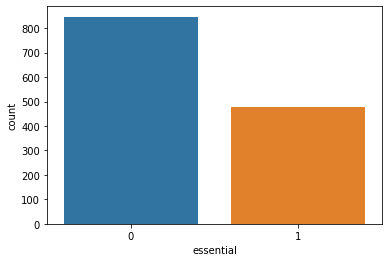

In [ ]:
ax = sns.countplot(x="essential", data=dataset1)

In [ ]:
# fit model on training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
predit = model.predict(X_test)

In [ ]:
X_test.shape # size of test data

(265, 342)

In [ ]:
print(classification_report(y_test,predit))
roc_auc = metrics.roc_auc_score(y_test,predit)
print('roc_auc',roc_auc)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       156
           1       0.97      0.94      0.96       109

    accuracy                           0.97       265
   macro avg       0.97      0.96      0.96       265
weighted avg       0.97      0.97      0.97       265

roc_auc 0.9628616796047987


In [ ]:
results = classification_report(y_test,predit,output_dict=True)
results['roc_auc'] = roc_auc
results

{'0': {'f1-score': 0.9714285714285713,
  'precision': 0.9622641509433962,
  'recall': 0.9807692307692307,
  'support': 156},
 '1': {'f1-score': 0.958139534883721,
  'precision': 0.9716981132075472,
  'recall': 0.944954128440367,
  'support': 109},
 'accuracy': 0.9660377358490566,
 'macro avg': {'f1-score': 0.9647840531561461,
  'precision': 0.9669811320754718,
  'recall': 0.9628616796047988,
  'support': 265},
 'roc_auc': 0.9628616796047987,
 'weighted avg': {'f1-score': 0.9659625148874819,
  'precision': 0.9661445354218583,
  'recall': 0.9660377358490566,
  'support': 265}}

In [ ]:
json = json.dumps(results)

# open file for writing, "w" 
f = open("results.json","w")
f.write(json)
f.close()

In [ ]:
precision = results['weighted avg']['precision']
recall = results['weighted avg']['recall']
fscore = results['weighted avg']['f1-score']